### [N-BEATS (Neural Basis Expansion Analysis for Time Series)](https://medium.com/@kylejones_47003/n-beats-for-time-series-forecasting-in-python-b4a61858fe49)

**N-BEATS (Neural Basis Expansion Analysis for Time Series)** is a deep learning model specifically designed for time series forecasting. It provides a flexible framework for _univariate_ and _multivariate_ forecasting tasks. N-BEATS works without requiring explicit feature engineering so it is more like an autoML tool than some of the other DL frameworks.

*N-BEATS* can capture patterns in time series data without needing prior training. This makes it a good choice for datasets where the underlying dynamics are not known or are too complicated for simpler models to grasp (looking at ARIMA).

*N-BEATS* is also a general-purpose model. It autonomously decomposes time series into components, such as trend and seasonality, without requiring explicit specification from the user. Basically it does all the hard work for feature engineering.

It is recursive which is unique and lets it generate predictions over extended time horizons. N-BEATS stacks multiple fully connected layers organized into blocks. Each block learns a specific pattern (e.g., trend or seasonality). First it does a **_Backward Pass_** to learns past components of the time series. then a **_Forward Pass_** to project future components for forecasting. and finally it considers Residuals and adjusts for any remaining unexplained variance.

In [1]:
!pip install -q numpy pandas matplotlib
!pip install -q scikit-learn

In [2]:
!pip install -q darts

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### Univariate Forecasting and Backtesting with N-BEATS

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.975    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Backtest Results:
MAPE: 10.35%
RMSE: 6.34
MAE: 5.69


Predicting: |                                                                                                 …

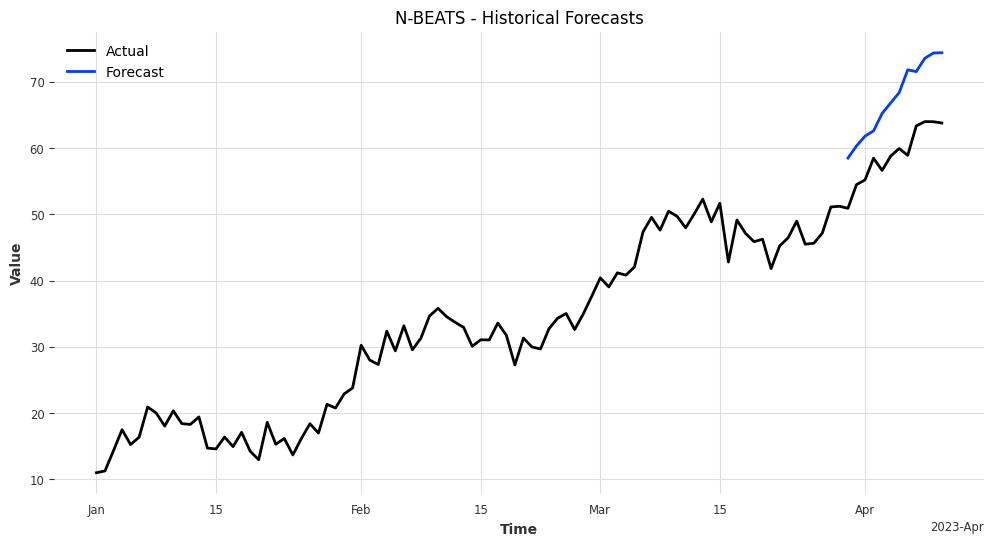

<Figure size 1000x600 with 0 Axes>

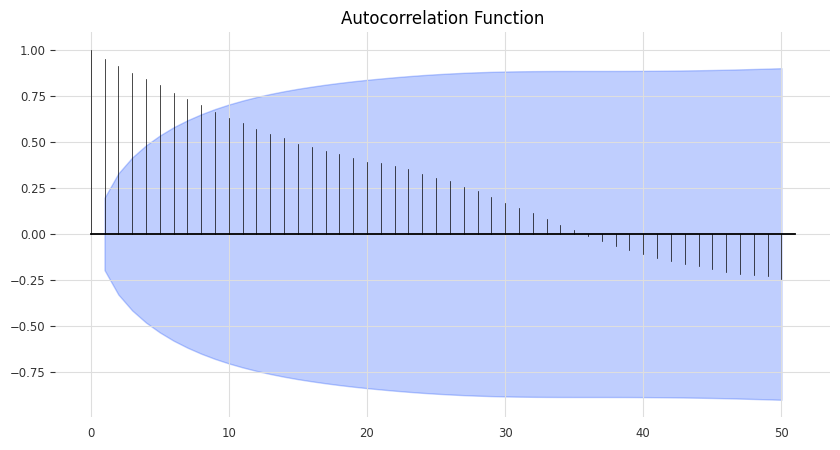

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mape, rmse, mae
from darts.utils.statistics import plot_acf

# Generate synthetic time series data
np.random.seed(42)
time = pd.date_range(start="2023-01-01", periods=100, freq="D")
data = 10 + 0.5 * np.arange(100) + 5 * np.sin(2 * np.pi * np.arange(100) / 30) + np.random.normal(scale=2, size=100)
df = pd.DataFrame({"Date": time, "Value": data})

# Create a TimeSeries object
series = TimeSeries.from_dataframe(df, time_col="Date", value_cols="Value")

# Split the data into train and test sets
train, test = series.split_before(0.8)

# Initialize the N-BEATS model
model = NBEATSModel(input_chunk_length=30, output_chunk_length=10, n_epochs=50, random_state=42)

# Fit the model
model.fit(train)

# Perform backtesting
backtest_results = model.backtest(
    series,
    start=0.8,  # Use 80% of the data for the first training
    forecast_horizon=10,
    stride=1,
    retrain=False,  # We've already fitted the model, so we don't need to retrain
    verbose=True,
    metric=[mape, rmse, mae],  # Using multiple metrics
)

# Print the backtest results
print("Backtest Results:")
print(f"MAPE: {backtest_results[0]:.2f}%")
print(f"RMSE: {backtest_results[1]:.2f}")
print(f"MAE: {backtest_results[2]:.2f}")

# Generate historical forecasts for plotting
historical_forecasts = model.historical_forecasts(
    series,
    start=0.8,
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True,
)

# Plot the results
plt.figure(figsize=(12, 6))
series.plot(label="Actual")
historical_forecasts.plot(label="Forecast")
plt.title("N-BEATS - Historical Forecasts")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
# plt.savefig("NBEATS_Backtest.png")
plt.show()

# Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(series, max_lag=50)
plt.title("Autocorrelation Function")
# plt.savefig("ACF_plot.png")
plt.show()

#### Multivariate Forecasting with N-BEATS

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.5 M  | train
-------------------------------------------------------------
6.5 M     Trainable params
1.6 K     Non-trainable params
6.5 M     Total params
25.925    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Multivariate Backtest Results:
MAPE: 9.52%
RMSE: 3.01
MAE: 2.71


Predicting: |                                                                                                 …

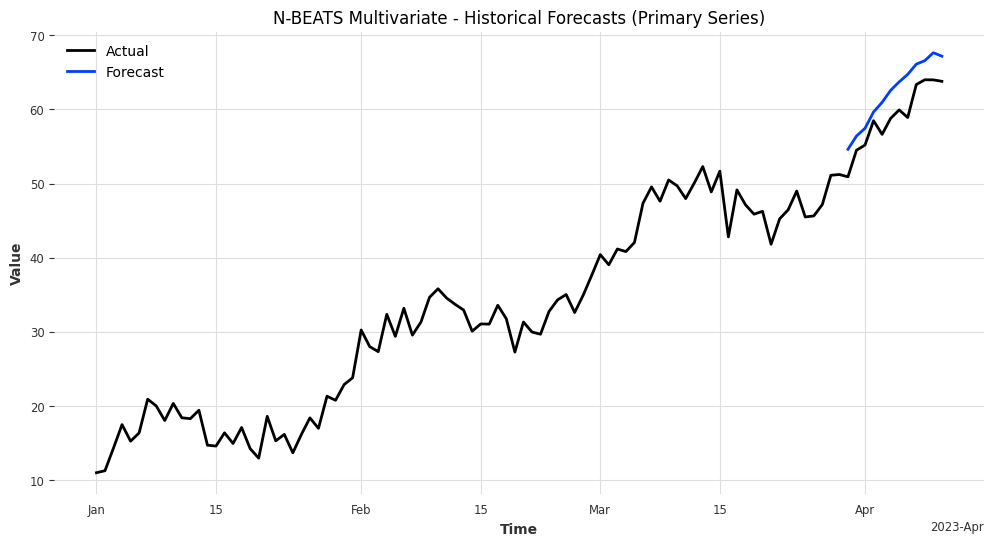

In [5]:
# Add a secondary variable (e.g., external temperature)
temperature = 20 + 2 * np.sin(2 * np.pi * np.arange(100) / 30) + np.random.normal(scale=1, size=100)
df["Temperature"] = temperature

# Create a multivariate TimeSeries
multivariate_series = TimeSeries.from_dataframe(df, time_col="Date", value_cols=["Value", "Temperature"])

# Split the multivariate data into train and test sets
multivariate_train, multivariate_test = multivariate_series.split_before(0.8)

# Initialize and train the N-BEATS model for multivariate data
multivariate_model = NBEATSModel(input_chunk_length=30, output_chunk_length=10, n_epochs=50, random_state=42)
multivariate_model.fit(multivariate_train)

# Perform backtesting on multivariate data
multivariate_backtest_results = multivariate_model.backtest(
    multivariate_series,
    start=0.8,
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True,
    metric=[mape, rmse, mae],
)

# Print the multivariate backtest results
print("\nMultivariate Backtest Results:")
print(f"MAPE: {multivariate_backtest_results[0]:.2f}%")
print(f"RMSE: {multivariate_backtest_results[1]:.2f}")
print(f"MAE: {multivariate_backtest_results[2]:.2f}")

# Generate historical forecasts for multivariate data
multivariate_historical_forecasts = multivariate_model.historical_forecasts(
    multivariate_series,
    start=0.8,
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True,
)

# Plot results for the primary series in multivariate forecast
plt.figure(figsize=(12, 6))
multivariate_series["Value"].plot(label="Actual")
multivariate_historical_forecasts["Value"].plot(label="Forecast")
plt.title("N-BEATS Multivariate - Historical Forecasts (Primary Series)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
# plt.savefig("NBEATS_Multivariate_Backtest.png")
plt.show()

#### Key Benefits

N-BEATS offers a trifecta of advantages for time series forecasting. Its flexible and can be used with a range of data types without requiring extensive customization. Its versatile means it can apply to financial markets or weather patterns or whatever. And, it is accurate.

Bonus: N-BEATS is surprisingly user-friendly.